# Python for Finance - Monte Carlo

In [1]:
import bsm_functions as bsm
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from time import time
from math import exp, sqrt, log
from random import gauss, seed

%matplotlib inline 

### Three approaches:
* Pure Python
* Vectorized NumPy
* Fully vectorized NumPy

Looking at the Black-Scholes-Merton stochastic differential equation:
$$dS_t = rS_tdt + \sigma S_tdZ_t$$

Euler discretization of the same equation:
$$S_t = S_{t-\Delta t}e^{((r-\frac{1}{2}\sigma^2)\Delta t + \sigma\sqrt{\Delta t}z_t}$$ 

The call option is approximated by:

$$ C_0 \approx e^{-rT}\frac{1}{I}\sum\limits_{I}h_tS_t(i)$$

We'll start by calculating an option value using the Black-Scholes-Morton equation above.

In [2]:
S0 = 100 # initial value
K = 105 # strike price
T = 1.0 # maturity
r = 0.05 # riskless short rate
sigma = 0.2 # volatility
bsm.bsm_call_value(S0,K,T,r,sigma)

8.0213522351431763

## Pure Python

In [3]:
# Setting the Monte Carlo parameters
seed(2000)
M = 50 # number of time steps
dt = T/M # length of time interval
I = 250000 # number of paths

#### Simulating I paths with M timesteps

In [4]:
t0 = time()
S = []
for i in range(I):
    path = []
    for t in range(M + 1):
        if t == 0:
            path.append(S0)
        else:
            z = gauss(0.0,1.0)
            St = path[t-1] * exp((r-0.5*sigma**2)*dt + sigma*sqrt(dt)*z)
            path.append(St)
    S.append(path)

# Calculating the Monte Carlo Estimator
C0 = exp(-r * T) * sum([max(path[-1] - K, 0) for path in S]) / I

tpy = time() - t0
print("European Option Value: %7.3f" %C0)
print("Duration in seconds: %7.3f" %tpy)

European Option Value:   8.011
Duration in seconds:  26.771



## Vectorized NumPy

In [5]:
np.random.seed(20000)
S0 = 100 # initial value
K = 105 # strike price
T = 1.0 # maturity
r = 0.05 # riskless short rate
M = 50 # number of time steps
sigma = 0.2 # volatility

In [6]:
t0 = time()
S = np.zeros((M+1,I))
S[0] = S0

for t in range(1, M+1):
    z = np.random.standard_normal(I)
    #vectorized operation per time step over all paths
    S[t] = S[t-1] * np.exp((r-0.5*sigma**2)*dt + sigma*sqrt(dt)*z)

C0 = exp(-r * T) * np.sum(np.maximum(S[-1] - K,0)) / I

tnp1 = time() - t0
print("European Option Value: %7.3f" %C0)
print("Duration in seconds: %7.3f" %tnp1)

European Option Value:   8.037
Duration in seconds:   0.982


## Full Vectorization with Log Euler Scheme

This alternative discretization of the Black-Scholes-Merton equation should be even faster than the previous approach.

$$logS_t = logS_{t-\Delta t} + (r-\frac{1}{2}\sigma^2)\Delta t + \sigma\sqrt{\Delta t}z_t$$

In [7]:
S0 = 100. # initial value
K = 105. # strike price
T = 1.0 # maturity
r = 0.05 # riskless short rate
M = 50 # number of time steps
sigma = 0.2 # volatility

In [8]:
t0 = time()
np.random.seed(20000)
I = 250000
dt = T/M
z = np.random.standard_normal((M+1, I))

S = S0 * np.exp(np.cumsum((r-0.5*sigma**2)*dt + sigma*sqrt(dt)*z,axis=0))
S[0] = S0

C0 =exp(-r*T) * sum(np.maximum(S[-1] - K,0)) / I
tnp2 = time()-t0

print("European Option Value: %7.3f" %C0)
print("Duration in seconds: %7.3f" %tnp2)

European Option Value:   8.166
Duration in seconds:   0.949


## Graphical Analysis
Looking at the first 10 paths of the Monte Carlo simulation:

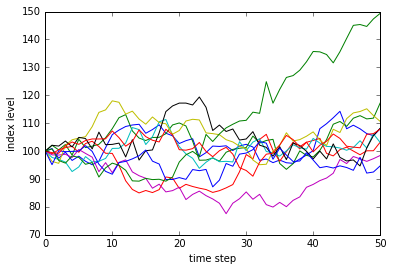

In [9]:
plt.plot(S[:,:10])
plt.grid = True
plt.xlabel('time step')
plt.ylabel('index level')

Frequency of the different levels in a histogram:

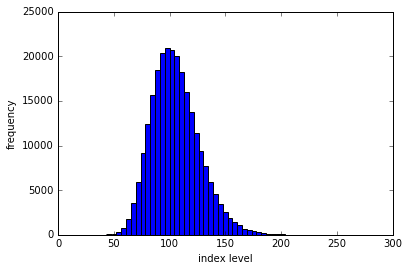

In [11]:
plt.hist(S[-1], bins = 50)
plt.grid = True
plt.xlabel('index level')
plt.ylabel('frequency')

Now looking at the options's end of period maturity inner values:

(0, 50000)

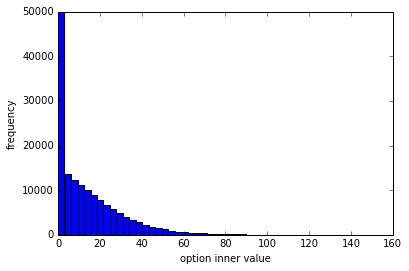

In [12]:
plt.hist(np.maximum(S[-1]-K,0),bins = 50)
plt.grid = True
plt.xlabel('option inner value')
plt.ylabel('frequency')
plt.ylim(0,50000)

In [13]:
# The number of simulated options expiring out of the money:
sum(S[-1]<K)

133533